In [1]:
import os
import re
import numpy as np
import pandas as pd
import scanpy as sc

base_dir = "/Volumes/jamboree/spatial/20250725__090712__Tuany_mSkinMelanoma5k_run1"
runs = [base_dir]  # or multiple run folders if you have them
ad_list = []

# ----- helpers -----
def parse_condition(sample_folder_name: str):
    """
    Your folders look like:
      output-XETG00045__0059976__litt_24h__20250725__091031
    The 'condition' is the 3rd token between '__': e.g. 'litt_24h'
    """
    parts = sample_folder_name.split("__")
    cond = parts[2] if len(parts) >= 3 else sample_folder_name

    # skin side (time-resolved)
    m = re.match(r"^(wt|cre|litt)_(\d+h)$", cond)
    if m:
        geno, tp = m.group(1), m.group(2)
        return {"condition": cond, "tissue": "skin", "genotype": geno, "timepoint": tp}

    # tumor side (genotype only)
    tumor_genos = {"Oprl1_cre","Oprl1_wt","Pdl1_cre","Pdl1_wt","c57"}
    if cond in tumor_genos:
        return {"condition": cond, "tissue": "tumor", "genotype": cond, "timepoint": None}

    # fallback
    return {"condition": cond, "tissue": None, "genotype": None, "timepoint": None}


def read_cells_csv(cell_info_path: str):
    df = pd.read_csv(cell_info_path, low_memory=False)
    # Try to find an index column
    idx_col = None
    for cand in ["cell_id", "barcode", "cellID", "id", "Unnamed: 0"]:
        if cand in df.columns:
            idx_col = cand
            break
    if idx_col is not None:
        df = df.set_index(idx_col)
    # If it's already indexed correctly, keep it
    if df.index.name is None:
        # last resort: use first column as index
        df = df.set_index(df.columns[0])
    return df


# ----- load -----
for run in runs:
    run_path = os.path.join(run)

    # only directories (skip .DS_Store)
    samples = [s for s in os.listdir(run_path)
               if os.path.isdir(os.path.join(run_path, s)) and not s.startswith(".")]

    for sample in samples:
        sample_path = os.path.join(run_path, sample)
        h5_path = os.path.join(sample_path, "cell_feature_matrix.h5")
        cell_info_path = os.path.join(sample_path, "cells.csv.gz")

        if not (os.path.exists(h5_path) and os.path.exists(cell_info_path)):
            print(f"Skipping {sample_path} (missing required files)")
            continue

        meta = parse_condition(sample)
        print(f"Loading: {sample}  →  {meta}")

        # 1) read counts
        ad_int = sc.read_10x_h5(h5_path)  # genes in .var, cells in .obs (barcodes)
        ad_int.var_names_make_unique()

        # 2) read and join cell metadata
        cell_info = read_cells_csv(cell_info_path)

        # ensure indices align: join by obs_names (barcodes)
        # (never overwrite ad_int.obs entirely—preserve existing cols)
        ad_int.obs = ad_int.obs.join(cell_info, how="left")

        # 3) add run/sample + parsed metadata
        ad_int.obs["run"] = os.path.basename(run)
        ad_int.obs["sample_folder"] = sample
        for k, v in meta.items():
            ad_int.obs[k] = v

        # 4) make obs names unique per sample
        ad_int.obs_names = sample + "_" + ad_int.obs_names.astype(str)

        ad_list.append(ad_int)

# ----- concatenate -----
if len(ad_list) == 0:
    raise RuntimeError("No samples loaded.")

adata_all = sc.concat(
    ad_list,
    label="sample_folder",
    join="outer",
    fill_value=0
)

print(adata_all)
print("Samples loaded:", adata_all.obs["sample_folder"].unique())
print("Tissues:", adata_all.obs["tissue"].value_counts(dropna=False))
print("Genotypes:", adata_all.obs["genotype"].value_counts(dropna=False))
print("Timepoints:", adata_all.obs["timepoint"].value_counts(dropna=False))

Loading: output-XETG00045__0059976__litt_24h__20250725__091031  →  {'condition': 'litt_24h', 'tissue': 'skin', 'genotype': 'litt', 'timepoint': '24h'}
Loading: output-XETG00045__0059973__Pdl1_wt__20250725__091031  →  {'condition': 'Pdl1_wt', 'tissue': 'tumor', 'genotype': 'Pdl1_wt', 'timepoint': None}
Loading: output-XETG00045__0059973__Oprl1_cre__20250725__091031  →  {'condition': 'Oprl1_cre', 'tissue': 'tumor', 'genotype': 'Oprl1_cre', 'timepoint': None}
Loading: output-XETG00045__0059976__litt_72h__20250725__091031  →  {'condition': 'litt_72h', 'tissue': 'skin', 'genotype': 'litt', 'timepoint': '72h'}
Loading: output-XETG00045__0059973__c57__20250725__091031  →  {'condition': 'c57', 'tissue': 'tumor', 'genotype': 'c57', 'timepoint': None}
Loading: output-XETG00045__0059976__cre_72h__20250725__091031  →  {'condition': 'cre_72h', 'tissue': 'skin', 'genotype': 'cre', 'timepoint': '72h'}
Loading: output-XETG00045__0059973__Oprl1_wt__20250725__091031  →  {'condition': 'Oprl1_wt', 'tissue

In [2]:
adata_all

AnnData object with n_obs × n_vars = 502783 × 5006
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'sample_folder', 'condition', 'tissue', 'genotype', 'timepoint'

In [3]:
sc.pp.calculate_qc_metrics(adata_all, percent_top=None, log1p=False, inplace=True)
sc.pp.filter_cells(adata_all,min_counts=20)


In [4]:
adata_all

AnnData object with n_obs × n_vars = 326144 × 5006
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'run', 'sample_folder', 'condition', 'tissue', 'genotype', 'timepoint', 'n_genes_by_counts', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [5]:
sc.pp.normalize_total(adata_all, inplace=True,target_sum=100)
sc.pp.log1p(adata_all)
#sc.pp.scale(ad, )#max_value=10)

In [6]:
import matplotlib.pyplot as plt

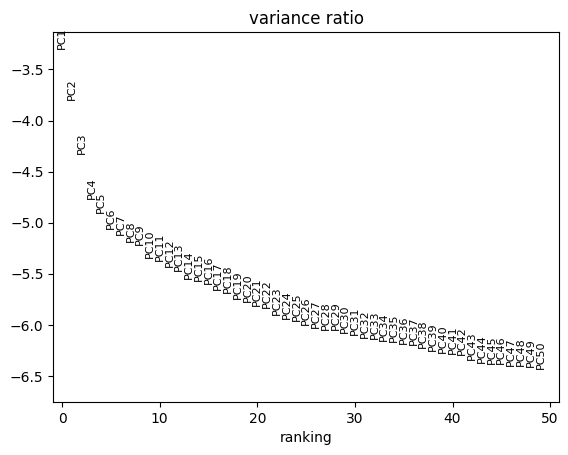

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [7]:
plt.rcdefaults()
sc.tl.pca(adata_all)
sc.pl.pca_variance_ratio(adata_all, n_pcs=50, log=True)
sc.pp.neighbors(adata_all, n_neighbors=15, n_pcs=0)

In [8]:
sc.tl.umap(adata_all, min_dist=0.1)

In [9]:
resolutions = [0.5, 1, 1.5 , 2, 2.5]
for resolution in resolutions: 
    print('clustering at resolution '+str(resolution))
    sc.tl.leiden(adata_all, resolution = resolution, key_added = 'leiden_'+str(resolution))
    print("done")

clustering at resolution 0.5
done
clustering at resolution 1
done
clustering at resolution 1.5
done
clustering at resolution 2
done
clustering at resolution 2.5
done


/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


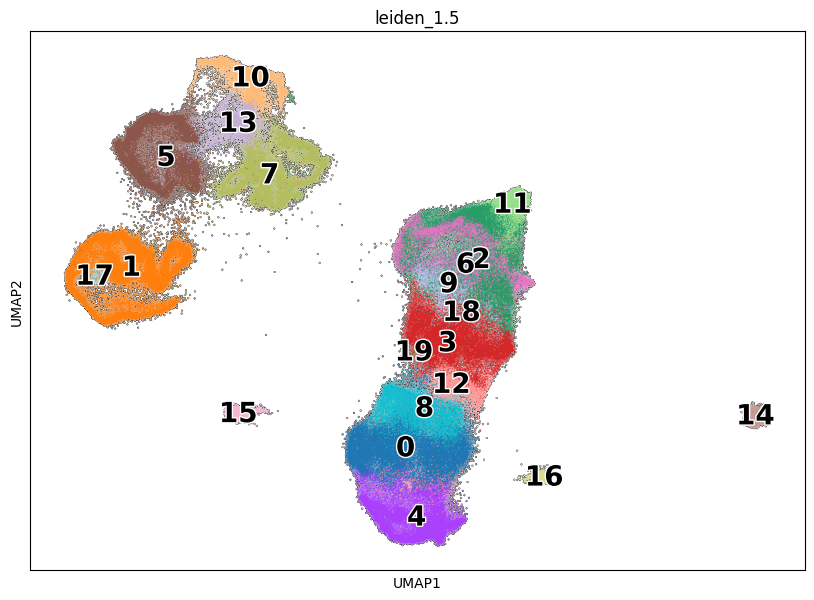

In [17]:
plt.rcdefaults()
with plt.rc_context({'figure.figsize': (10, 7)}):
    sc.pl.umap(adata_all,color = ("leiden_1.5"),s=3,add_outline=True,legend_loc='on data',legend_fontsize=20,legend_fontoutline=2, ncols= 1, )

In [11]:
adata_all.obs.columns

Index(['x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts',
       'genomic_control_counts', 'control_codeword_counts',
       'unassigned_codeword_counts', 'deprecated_codeword_counts',
       'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count',
       'segmentation_method', 'run', 'sample_folder', 'condition', 'tissue',
       'genotype', 'timepoint', 'n_genes_by_counts', 'n_counts', 'leiden_0.5',
       'leiden_1', 'leiden_1.5', 'leiden_2', 'leiden_2.5'],
      dtype='object')

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


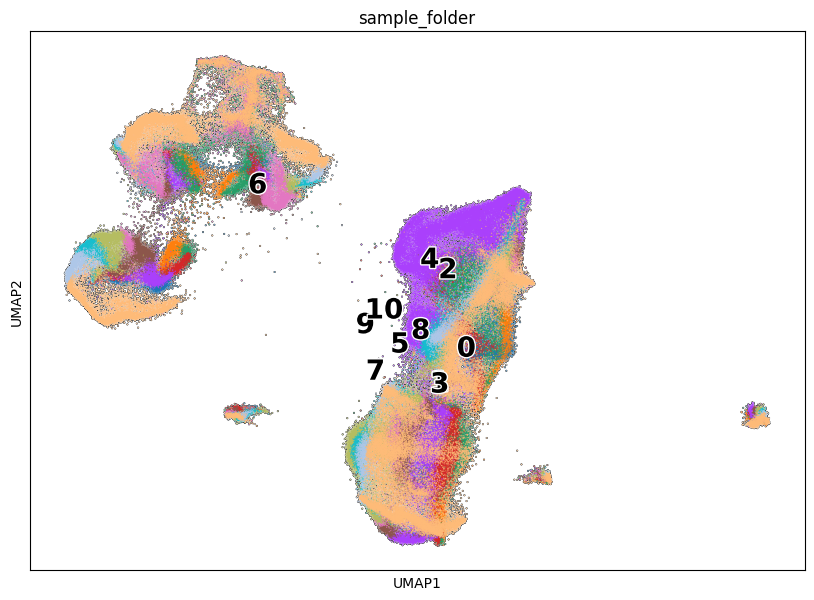

In [12]:
plt.rcdefaults()
with plt.rc_context({'figure.figsize': (10, 7)}):
    sc.pl.umap(adata_all,color = ("sample_folder"),s=3,add_outline=True,legend_loc='on data',legend_fontsize=20,legend_fontoutline=2, ncols= 1, )

/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:371: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:381: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/Users/christoffer/miniconda3/envs/sc/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


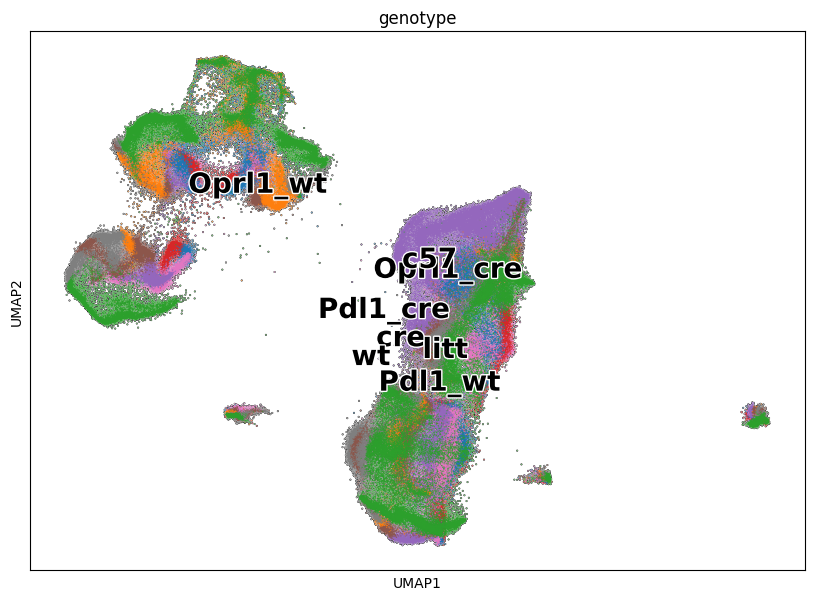

In [13]:
plt.rcdefaults()
with plt.rc_context({'figure.figsize': (10, 7)}):
    sc.pl.umap(adata_all,color = ("genotype"),s=3,add_outline=True,legend_loc='on data',legend_fontsize=20,legend_fontoutline=2, ncols= 1, )

In [14]:
spatial = np.array(adata_all.obs[['x_centroid','y_centroid']])
adata_all.obsm['spatial'] = spatial

0


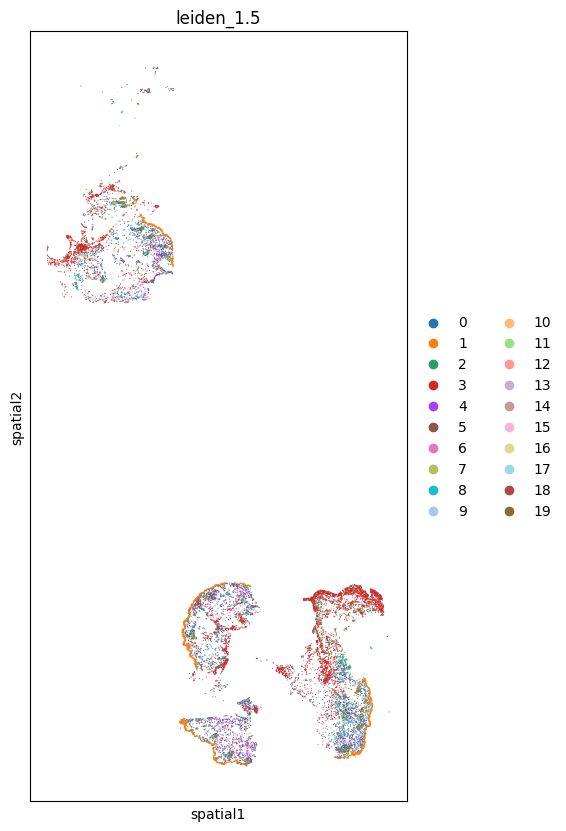

1


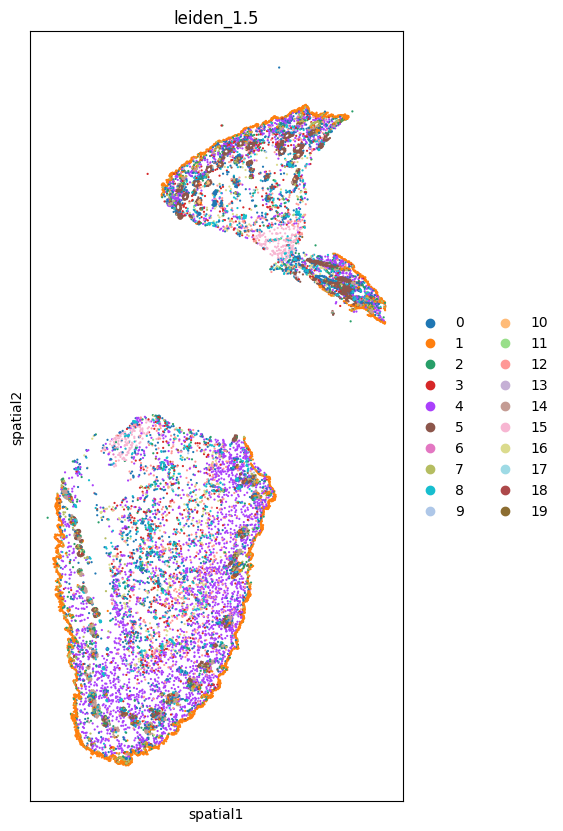

2


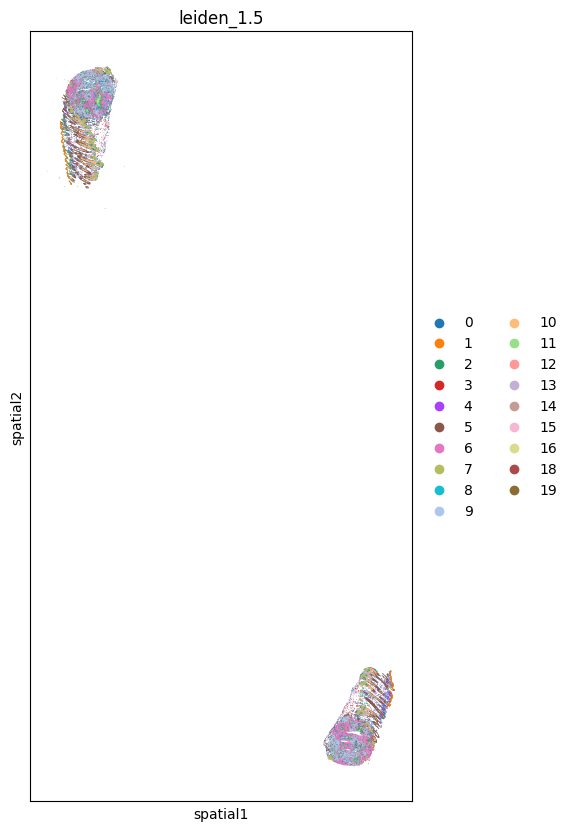

3


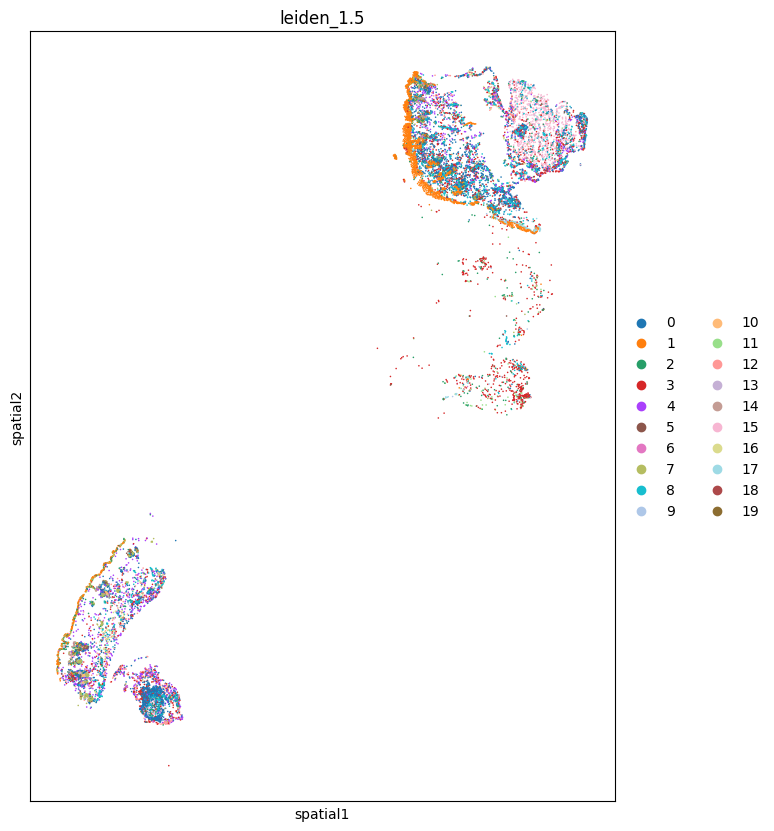

4


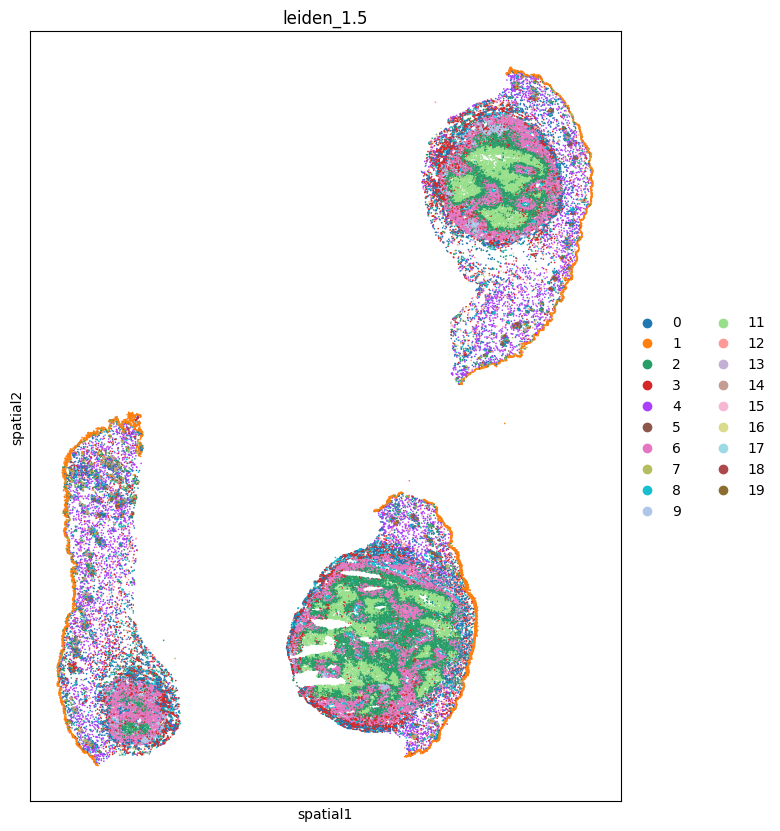

5


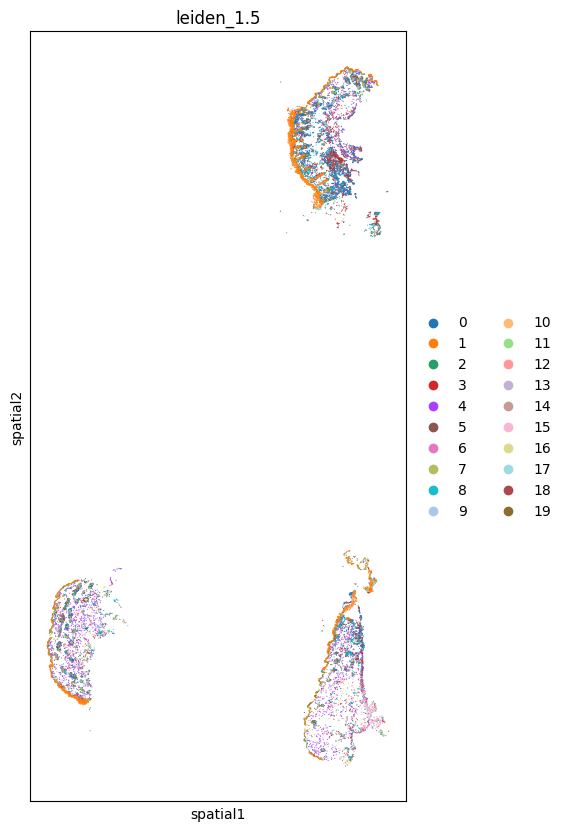

6


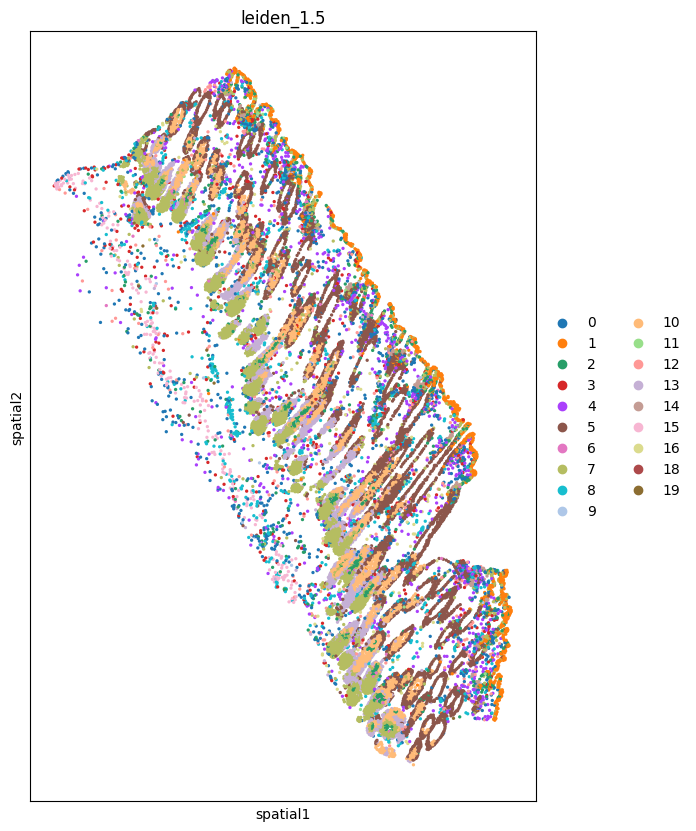

7


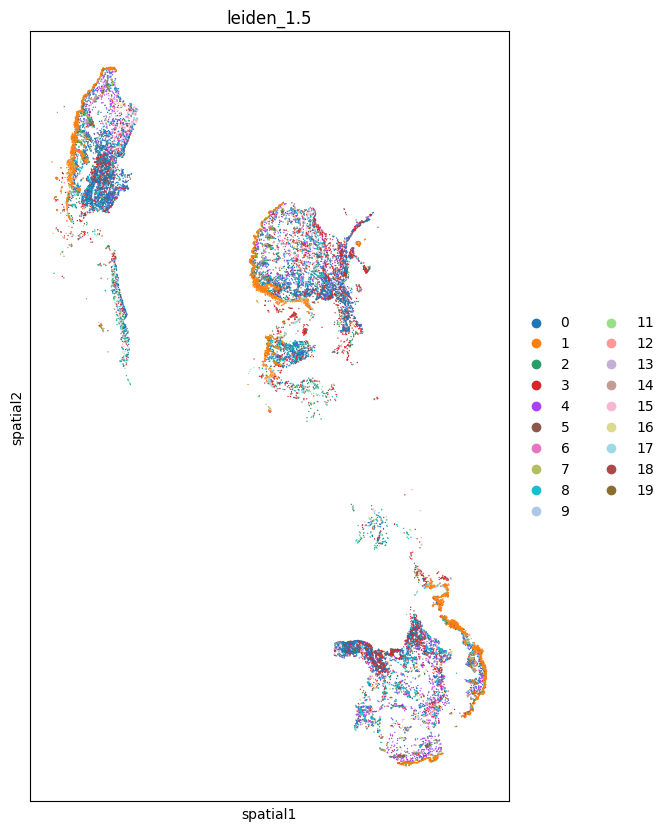

8


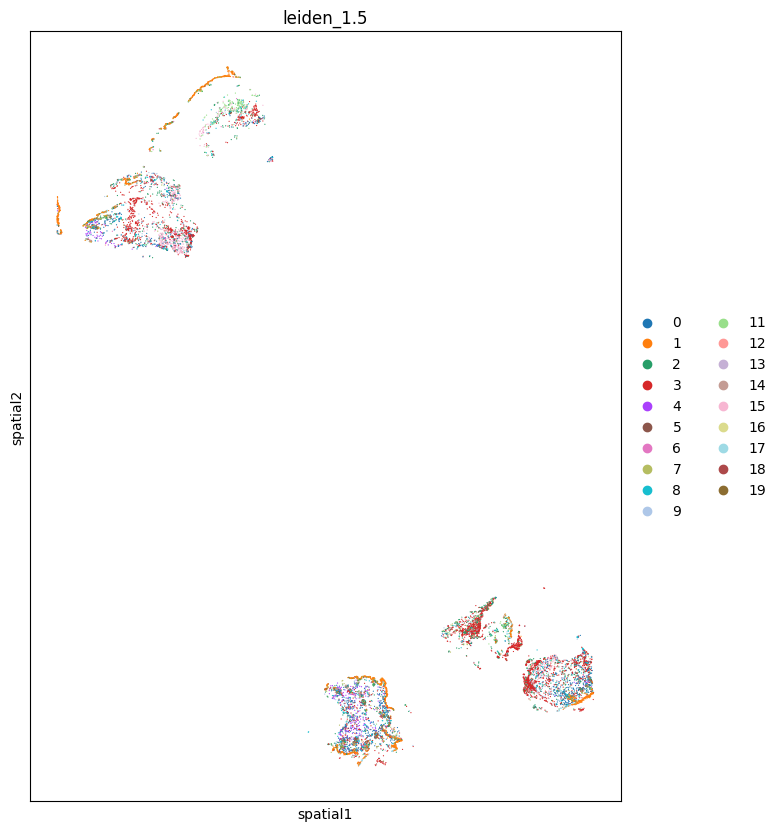

9


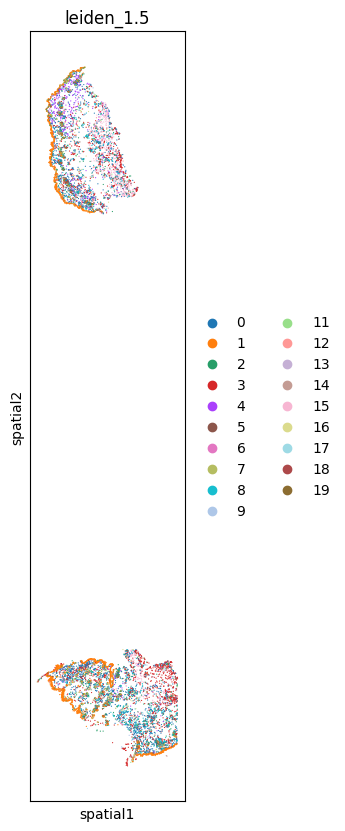

10


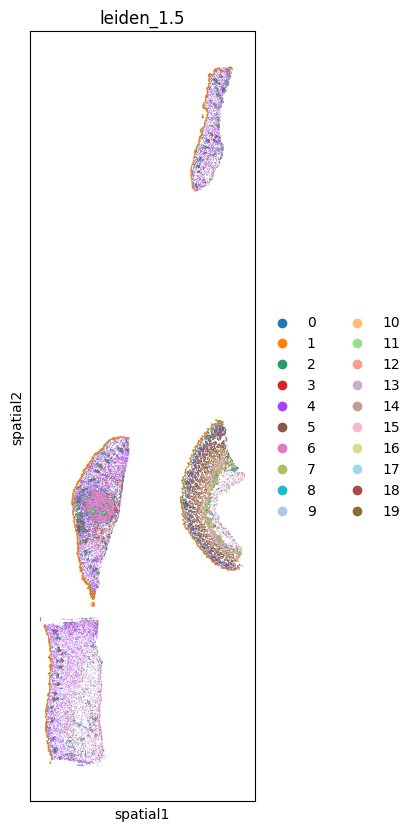

In [18]:
for run in adata_all.obs['sample_folder'].unique():
    print(run)
    ad_int = adata_all[adata_all.obs['sample_folder'] == run]
    with plt.rc_context({'figure.figsize': (20, 10)}):
        sc.pl.spatial(ad_int, spot_size=20, color = 'leiden_1.5')
    plt.show()
    

In [16]:
adata_all.write('../data/min_counts_20_min_genes_NaN.h5ad')